In [ ]:
import torch
from pathlib import Path

from data.dataGenerator import generate_data
from train import train_direction
from infer import load_model, translate_with_attention, show_attention

# Práctica: LSTM con atención de Bahdanau

En este notebook se presenta la implementación y evaluación de un modelo *sequence-to-sequence*
(seq2seq) con atención de Bahdanau.

El objetivo de esta práctica no es construir un traductor realista, sino **demostrar de forma
experimental cómo el mecanismo de atención permite al decodificador alinearse dinámicamente con
las distintas posiciones de la secuencia de entrada**, superando la limitación del vector de contexto fijo
de los modelos seq2seq clásicos.

Para ello se utiliza un **dataset sintético de traducción español–inglés**, que permite analizar
el comportamiento del modelo de forma controlada y visualizar explícitamente los pesos de atención.

## Estructura del proyecto

El proyecto se encuentra dividido en varios ficheros y se ejecutará todo en este notebook:

- **train.py**  
  Contiene toda la lógica de entrenamiento:
  - construcción del dataset y dataloader
  - definición del modelo Seq2Seq con atención
  - bucle de entrenamiento por épocas
  - guardado automático del mejor modelo

- **infer.py**  
  Contiene la lógica de inferencia:
  - carga de modelos entrenados
  - traducción con extracción de pesos de atención

- **model.py**  
  Implementa el Encoder, Decoder con atención de Bahdanau y la clase Seq2Seq.

- **dataset.py**  
  Gestiona el vocabulario, la tokenización y el padding de las secuencias.

## 1. Configuración del experimento

En esta celda se definen los hiperparámetros que se van a usar y se importan las funciones de los ficheros y las librerías que se usarán.

Entre los parámetros configurables se incluyen:
- tamaño de los embeddings
- dimensiones ocultas del encoder y decoder
- ratio de teacher forcing
- número de épocas
- tamaño de batch

El dispositivo (CPU/GPU) se selecciona automáticamente en función de la disponibilidad.


In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE =", DEVICE)

DATA_PATH = "data/es-en.txt"  
N_SAMPLES = 2500              
MIN_FREQ = 1                  
BATCH_SIZE = 64
EPOCHS = 15
LR = 5e-4
CLIP = 1.0
TEACHER_FORCING = 0.6

EMB_DIM = 64
ENC_HID_DIM = 128
DEC_HID_DIM = 128
ATTN_DIM = 64

MAX_LEN = 30
DIRECTION = "es-en"
MODEL_PATH = f"seq2seq_bahdanau_{DIRECTION}.pt"

DEVICE = cpu


## 2. Generación del dataset
Para las pruebas se utiliza un dataset sintético de pares Español–Inglés generado automáticamente a partir del fichero dataGenerator.py.

Esta celda es opcional ya que si se dispone del dataset no es necesario volver a crearlo. En caso de que no se tenga, hay que ejecutarla.

In [3]:
generate_data(n=N_SAMPLES, out_path='data/es-en.txt')

print("Dataset generado en:", DATA_PATH)

with open(DATA_PATH, "r", encoding="utf-8") as f:
    for i in range(5):
        print(f.readline().strip())

Wrote 2500 pairs to data\es-en.txt
Dataset generado en: data/es-en.txt
hoy yo leo ||| today i read
yo leo en la ciudad ||| i read in the city
el estudiante está grande en la ciudad ||| the student is big in the city
ahora la casa está cansado ||| now the house is tired
ahora yo está listo ||| now i is smart


## 3. Arquitectura del modelo

El modelo implementado sigue la arquitectura clásica *encoder–decoder* con atención:

- **Encoder**: LSTM bidireccional que procesa la secuencia de entrada y genera una secuencia de
  anotaciones ocultas $$(h_1, \dots, h_{T_x})$$
- **Mecanismo de atención de Bahdanau**: calcula, en cada paso de decodificación, un conjunto de
  pesos de atención $$(\alpha_{ij})$$ mediante un *score aditivo*.
- **Decoder**: LSTM que genera la secuencia de salida utilizando el estado previo, el vector de contexto
  calculado por la atención y el token generado anteriormente.

Además, se proyectan los estados finales del encoder al espacio del decoder para inicializar correctamente
el proceso de decodificación.



## 4. Entrenamiento del modelo

El entrenamiento se realiza llamando directamente a la función train_direction definida en `train.py`.

Durante el entrenamiento:
- el modelo se entrena con atención de Bahdanau
- se emplea teacher forcing decreciente
- se aplica gradient clipping
- se guarda automáticamente el mejor modelo según la pérdida de entrenamiento

Se entrenan ambos sentidos de traducción:
- Español → Inglés
- Inglés → Español

Cada modelo se entrena por separado y se guarda el checkpoint correspondiente que incluye:
- los pesos del modelo,
- la configuración de la arquitectura,
- los vocabularios de origen y destino,
- y los índices especiales (pad, sos, eos).

Esto permite reconstruir el modelo posteriormente para realizar inferencia sin necesidad de
volver a entrenar.


In [4]:
train_direction("es-en")   
train_direction("en-es")

ckpt_es_en = Path("seq2seq_bahdanau_es-en.pt")
ckpt_en_es = Path("seq2seq_bahdanau_en-es.pt")
print("Checkpoint español-inglés:", ckpt_es_en, "->", "OK" if ckpt_es_en.exists() else "NO EXISTE")
print("Checkpoint inglés-español:", ckpt_en_es, "->", "OK" if ckpt_en_es.exists() else "NO EXISTE")    


Entrenando dirección: es-en
SRC vocab size: 54
TRG vocab size: 55
Ejemplo SRC vocab: ['<pad>', '<sos>', '<eos>', '<unk>', 'el', 'está', 'en', 'la', 'trabajo', 'universidad', 'ciudad', 'casa', 'mi', 'cada', 'día']
Ejemplo TRG vocab: ['<pad>', '<sos>', '<eos>', '<unk>', 'the', 'is', 'in', 'at', 'work', 'university', 'city', 'my', 'day', 'every', 'now']
Epoch 01 | Loss: 3.4645 | TF: 0.600
Epoch 02 | Loss: 2.4739 | TF: 0.570
Epoch 03 | Loss: 1.4156 | TF: 0.541
Epoch 04 | Loss: 0.6378 | TF: 0.514
Epoch 05 | Loss: 0.2276 | TF: 0.489
Epoch 06 | Loss: 0.0914 | TF: 0.464
Epoch 07 | Loss: 0.0488 | TF: 0.441
Epoch 08 | Loss: 0.0318 | TF: 0.419
Epoch 09 | Loss: 0.0224 | TF: 0.398
Epoch 10 | Loss: 0.0169 | TF: 0.378
Epoch 11 | Loss: 0.0133 | TF: 0.359
Epoch 12 | Loss: 0.0108 | TF: 0.341
Epoch 13 | Loss: 0.0090 | TF: 0.324
Epoch 14 | Loss: 0.0077 | TF: 0.308
Epoch 15 | Loss: 0.0067 | TF: 0.293
Epoch 16 | Loss: 0.0057 | TF: 0.278
Epoch 17 | Loss: 0.0051 | TF: 0.264
Epoch 18 | Loss: 0.0045 | TF: 0.25

## 5. Inferencia

Una vez entrenados y guardados los modelos de traducción, la inferencia se realiza desde este cuaderno utilizando la función translate_with_attention definida en infer.py.

Esta función permite:
- generar la traducción de una frase de entrada
- recuperar los pesos de atención αᵢⱼ asociados a cada paso de decodificación

Aunque el modelo utiliza atención de Bahdanau en todos los casos, esta función permite exponer explícitamente la matriz de atención aprendida, devolviendo:

- la secuencia de palabras traducidas
- la matriz de atención αᵢⱼ
- los tokens de la frase de entrada

Se muestran ejemplos de traducción en ambas direcciones:
- Español → Inglés
- Inglés → Español

### 5.1 Español a Inglés



Español a Inglés

Frase origen: mañana mi hermano está en la universidad
Traducción: tomorrow my is at the university


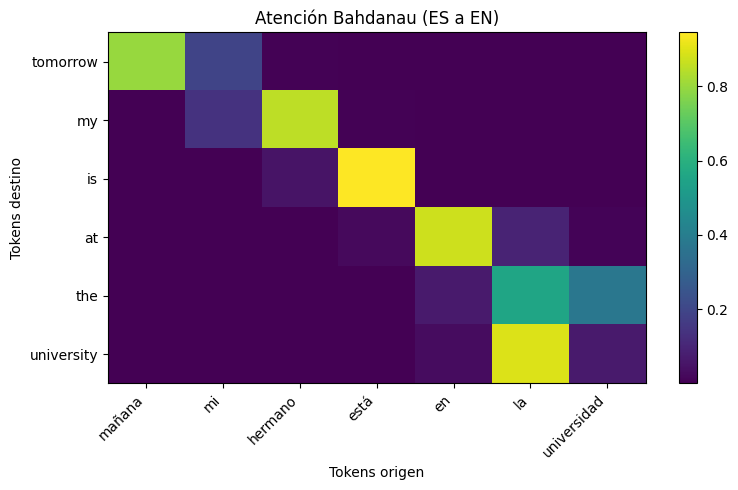


Frase origen: el perro está feliz en el restaurante
Traducción: the dog is happy in the restaurant


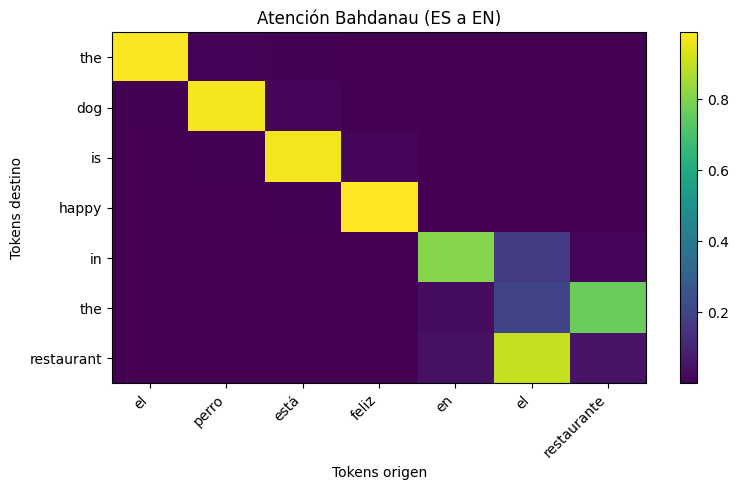

In [8]:
print("\nEspañol a Inglés")

model, src_vocab, trg_vocab, src_pad, sos, eos = load_model(
    "seq2seq_bahdanau_es-en.pt"
)

sentences_es = [
    "mañana mi hermano está en la universidad",
    "el perro está feliz en el restaurante",
]

for s in sentences_es:
    print("\nFrase origen:", s)



    # Con atención
    out_attn, attn, src_tokens = translate_with_attention(
        model, src_vocab, trg_vocab, src_pad, sos, eos, s
    )
    print("Traducción:", " ".join(out_attn))

    if attn is not None:
        show_attention(
            attn,
            src_tokens,
            out_attn,
            title="Atención Bahdanau (ES a EN)",
        )

### 5.2 Inglés a Español


Inglés a Español

Frase origen: the cat is small and in the house
CON atención: el gato está pequeño en la ciudad


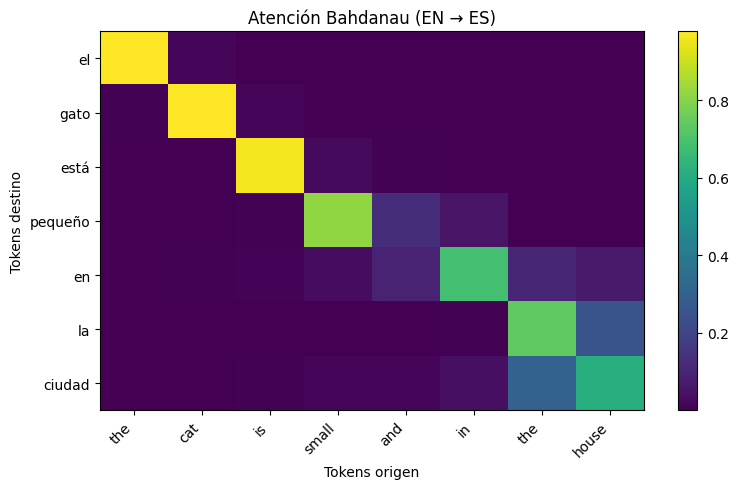


Frase origen: my brother is happy at home
CON atención: mi hermana está feliz en casa


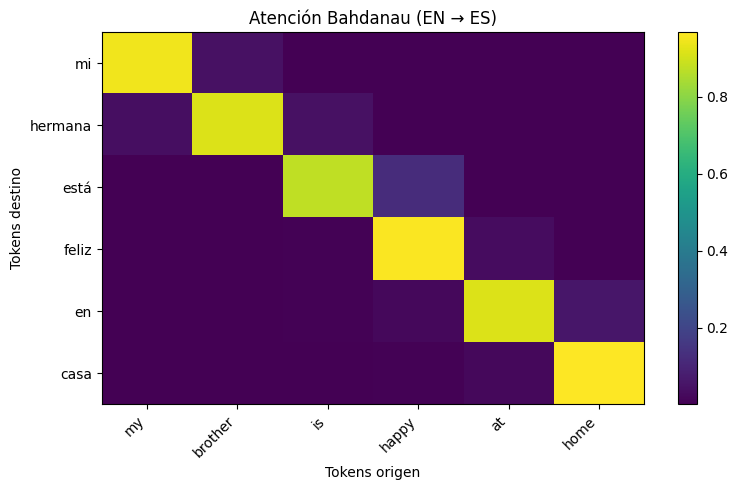

In [10]:
print("\nInglés a Español")

model, src_vocab, trg_vocab, src_pad, sos, eos = load_model(
    "seq2seq_bahdanau_en-es.pt"
)

sentences_en = [
    "the cat is small and in the house",
    "my brother is happy at home",
]

for s in sentences_en:
    print("\nFrase origen:", s)

    out_attn, attn, src_tokens = translate_with_attention(
        model, src_vocab, trg_vocab, src_pad, sos, eos, s
    )
    print("CON atención:", " ".join(out_attn))

    if attn is not None:
        show_attention(
            attn,
            src_tokens,
            out_attn,
            title="Atención Bahdanau (EN → ES)",
        )

## 6. Análisis de inferencia

### Calidad de las traducciones

En los ejemplos que se han hecho, el modelo es capaz de generar traducciones gramaticalmente correctas y semánticamente coherentes en ambas direcciones (Español a Inglés e Inglés a Español). Las traducciones conservan el significado generañ de las oraciones y léxicamente siguen manteniendo una estructura adecuada en cuanto a los sustantivos, verbos y preposiciones.

En algunos casos aparecen pequeños errores morfosintácticos, como la omisión de un sustantivo (“my is at the university” en lugar de “my brother is at the university”), que entra dentro de lo esperado ya que el modelo ha sido entrenado sobre un conjunto de datos reducido y sintético. Aun así el contenido semántico principal se preserva correctamente.

En otros ejemplos, como “el perro está feliz en el restaurante” → “the dog is happy in the restaurant”, la traducción es prácticamente perfecta, demostrando que el modelo ha aprendido correctamente las correspondencias básicas entre ambos idiomas.


### Análisis del mecanismo de atención de Bahdanau

Las visualizaciones de atención muestran un patrón claro de alineamiento entre las palabras de la frase origen y las palabras generadas en la traducción. En la mayoría de los casos se observa una diagonal dominante en los mapas de calor, lo que indica que el modelo aprende una correspondencia casi uno a uno entre los tokens de entrada y salida.

Las palabras de contenido (sustantivos y verbos principales) concentran los mayores pesos de atención en las posiciones correctas, mientras que las palabras funcionales (preposiciones y artículos) presentan distribuciones de atención más difusas, un comportamiento coherente con su papel sintáctico.

En la dirección Inglés → Español, la atención refleja adecuadamente los cambios de orden propios de la traducción entre ambos idiomas. Esto confirma que el modelo no depende de un único vector fijo, sino que utiliza correctamente un vector de contexto dinámico para cada paso del decoder.



## 7. Conclusión general del proyecto

En este proyecto se ha implementado y evaluado un sistema de traducción automática basado en una arquitectura Seq2Seq con atención de Bahdanau, usando una red LSTM.

Los resultados obtenidos permiten concluir que:

- El modelo aprende correctamente la tarea de traducción en ambos sentidos (Español → Inglés e Inglés → Español).
- El mecanismo de atención de Bahdanau funciona de acuerdo con su formulación teórica, permitiendo al decodificador centrarse continuamente en distintas partes de la frase de entrada en cada paso de generación.
- La visualización de los pesos de atención confirma la existencia de alineamientos coherentes entre palabras fuente y destino.
- A pesar de las limitaciones del dataset, los resultados son suficientes para validar el enfoque y cumplir los objetivos de la práctica.

En conjunto, el proyecto demuestra tanto el funcionamiento práctico como el fundamento teórico de los modelos de atención en traducción automática.